In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append("../lib")
import segmentation as sg

In [3]:
from skimage import io
reload(sg)
    
img = io.imread('../data/card.jpg')
text_segments = sg.text_segments(img)

In [4]:
def extract(img, segment):
    return img[segment[0]:segment[2], segment[1]:segment[3]]

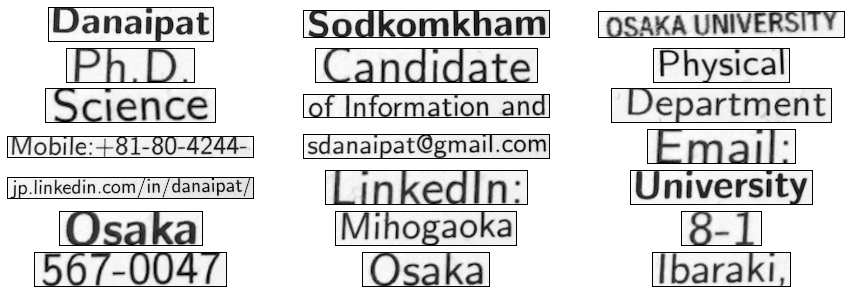

In [5]:
grayscale_img = sg.rgb2grayscale(img)
segments = [extract(grayscale_img, seg) for seg in text_segments]

plt.gcf().set_size_inches(15, 5)
for i, s in enumerate(segments):
    plt.subplot(len(segments)/3, 3, i + 1)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.imshow(s, cmap=plt.cm.gray)

In [13]:
# generate artificial training data
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import string
import random
import os


characters = string.ascii_letters + string.digits
font_path = "/Library/Fonts/"
font_choices = ["Arial.ttf",
                "Arial Black.ttf",
                "Arial Bold Italic.ttf",
                "Arial Bold.ttf",
                "Arial Italic.ttf",
                "Arial Narrow Bold Italic.ttf",
                "Arial Narrow Bold.ttf",
                "Arial Narrow Italic.ttf",
                "Arial Narrow.ttf",
                "Arial Rounded Bold.ttf",
                "Arial Unicode.ttf"]

W = 18
H = 24    

# Generate AZaz09
for c in characters:
    if c in string.uppercase:
        dir_path = "../data/dataset/uppercase/%s/" % c
    elif c in string.lowercase:
        dir_path = "../data/dataset/lowercase/%s/" % c
    elif c in string.digits:
        dir_path = "../data/dataset/digits/%s/" % c
    try:
        os.makedirs(dir_path)
    except OSError as e:
        print e
    for i in range(2000):
        cl = random.choice(characters)
        cr = random.choice(characters)
        img = Image.new("L", (W, H), 255 - random.randint(0, 50))
        draw = ImageDraw.Draw(img)
        font_name = random.choice(font_choices)
        font = ImageFont.truetype(font_path+font_name, 22 + random.randint(-2, 3))
        w1, _ = draw.textsize(cl, font=font)
        w2, _ = draw.textsize(cr, font=font)
        w, _ = draw.textsize(cl + c + cr, font=font)
        mid = (w1 + (w - w1 - w2)/2)
        draw.text((-(mid - W/2), random.randint(-3, 3)), cl + c + cr, random.randint(0, 50), font=font)
        img.save(dir_path + "%d.png" % (i))

[Errno 17] File exists: '../data/dataset/small/a/'
[Errno 17] File exists: '../data/dataset/small/b/'
[Errno 17] File exists: '../data/dataset/small/c/'
[Errno 17] File exists: '../data/dataset/small/d/'
[Errno 17] File exists: '../data/dataset/small/e/'
[Errno 17] File exists: '../data/dataset/small/f/'
[Errno 17] File exists: '../data/dataset/small/g/'
[Errno 17] File exists: '../data/dataset/small/h/'
[Errno 17] File exists: '../data/dataset/small/i/'
[Errno 17] File exists: '../data/dataset/small/j/'
[Errno 17] File exists: '../data/dataset/small/k/'
[Errno 17] File exists: '../data/dataset/small/l/'
[Errno 17] File exists: '../data/dataset/small/m/'


In [16]:
# Generate ""
i = 0

dir_path = "../data/dataset/empty/"
try:
    os.makedirs(dir_path)
except OSError as e:
    print e

for _ in range(3):
    for c1 in characters:
        for c2 in characters:
            img = Image.new("L", (W, H), 255 - random.randint(0, 50))
            draw = ImageDraw.Draw(img)
            font_name = random.choice(font_choices)
            font = ImageFont.truetype(font_path+font_name, 22 + random.randint(-2, 3))
            w1, _ = draw.textsize(c1, font=font)
            w2, _ = draw.textsize(c2, font=font)
            w, _ = draw.textsize(c1 + c2, font=font)
            mid = (w1 + (w - w1 - w2)/2)
            draw.text((-(mid - W/2) + random.randint(-2, 2), random.randint(-3, 3)), c1 + c2, random.randint(0, 50), font=font)
            img.save("../data/dataset/empty/%d.png" % i)
            i += 1

In [19]:
from skimage import io


X = []
y = []

for i, c in enumerate(characters):
    if c in string.uppercase:
        dir_path = "../data/dataset/uppercase/%s/" % c
    elif c in string.lowercase:
        dir_path = "../data/dataset/lowercase/%s/" % c
    elif c in string.digits:
        dir_path = "../data/dataset/digits/%s/" % c
        
    path, dirs, files = os.walk(dir_path).next()
    N = len(files)
    for j in range(len(files)):
        y.append(i)
        X.append(io.imread(dir_path + "%s.png" % j).reshape(W*H))

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

In [20]:
print X.shape, y.shape

(124000, 432) (124000,)


In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [172]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.cross_validation import cross_val_predict
# from sklearn.metrics import classification_report


# pred = cross_val_predict(LogisticRegression(), X[indexes], y[indexes], cv=10, n_jobs=3)
# print classification_report(y, pred)

In [45]:
from lasagne.nonlinearities import softmax
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        ('hidden2', layers.DenseLayer),
        ('dropout2', layers.DropoutLayer),
#         ('hidden3', layers.DenseLayer),
#         ('dropout3', layers.DropoutLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, W * H),  
    hidden1_num_units=512,
    dropout1_p=0.4,
    hidden2_num_units=256,
    dropout2_p=0.5,
#     hidden3_num_units=128,
#     dropout3_p=0.5,
    output_nonlinearity=softmax,  
    output_num_units=len(characters),  

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.0001,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're dealing with regression problem
    max_epochs=100,  # we want to train this many epochs
    verbose=1,
    )

In [46]:
N = len(X)
indexes = range(N)
np.random.shuffle(indexes)

net = net.fit(X[indexes], y[indexes])

  DenseLayer        	(None, 62)          	produces      62 outputs
  DropoutLayer      	(None, 256)         	produces     256 outputs
  DenseLayer        	(None, 256)         	produces     256 outputs
  DropoutLayer      	(None, 512)         	produces     512 outputs
  DenseLayer        	(None, 512)         	produces     512 outputs
  InputLayer        	(None, 432)         	produces     432 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    4.573839  |    4.037689  |     1.132786  |      4.05%  |  10.9s
     2  |    4.269602  |    3.911026  |     1.091684  |      8.45%  |  11.1s
     3  |    4.112903  |    3.817935  |     1.077258  |     12.55%  |  10.9s
     4  |    3.996477  |    3.726868  |     1.072342  |     16.11%  |  11.0s
     5  |    3.891547  |    3.626381  |     1.073121  |     19.82%  |  10.9s
     6  |    3.792776  |    3.514702  |     1.079117  |     

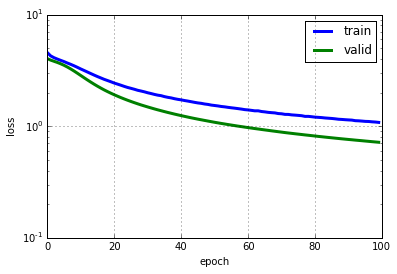

In [47]:
train_loss = np.array([i["train_loss"] for i in net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.yscale("log")
pyplot.show()

In [51]:
net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
#         ('conv2', layers.Conv2DLayer),
#         ('pool2', layers.MaxPool2DLayer),
#         ('conv3', layers.Conv2DLayer),
#         ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, H, W),
    conv1_num_filters=16, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2), dropout1_p=0.1,
#     conv2_num_filters=32, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
#     conv3_num_filters=64, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=256, dropout4_p=0.4,
    hidden5_num_units=256,
    output_num_units=len(characters), 
    output_nonlinearity=softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    regression=False,
    max_epochs=1000,
    verbose=1,
    )

In [52]:
indexes = range(N)
np.random.shuffle(indexes)

net = net2.fit(X.reshape(N, 1, H, W)[indexes], y[indexes])

  DenseLayer        	(None, 62)          	produces      62 outputs
  DenseLayer        	(None, 256)         	produces     256 outputs
  DropoutLayer      	(None, 256)         	produces     256 outputs
  DenseLayer        	(None, 256)         	produces     256 outputs
  DropoutLayer      	(None, 16, 11, 8)   	produces    1408 outputs
  MaxPool2DLayer    	(None, 16, 11, 8)   	produces    1408 outputs
  Conv2DLayer       	(None, 16, 22, 16)  	produces    5632 outputs
  InputLayer        	(None, 1, 24, 18)   	produces     432 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    4.139626  |    4.088069  |     1.012612  |      3.57%  |  68.9s
     2  |    4.094904  |    4.047505  |     1.011711  |      5.52%  |  58.2s
     3  |    4.053963  |    3.995984  |     1.014509  |      8.11%  |  51.4s
     4  |    4.003677  |    3.918694  |     1.021687  |     10.79%  |  60.2s
   

KeyboardInterrupt: 

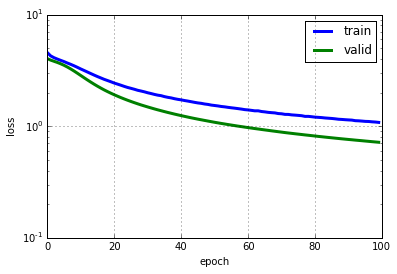

In [53]:
train_loss = np.array([i["train_loss"] for i in net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.yscale("log")
pyplot.show()

In [89]:
import cPickle as pickle
with open('OCR-net-conv.pickle', 'wb') as f:
    pickle.dump(net2, f, -1)

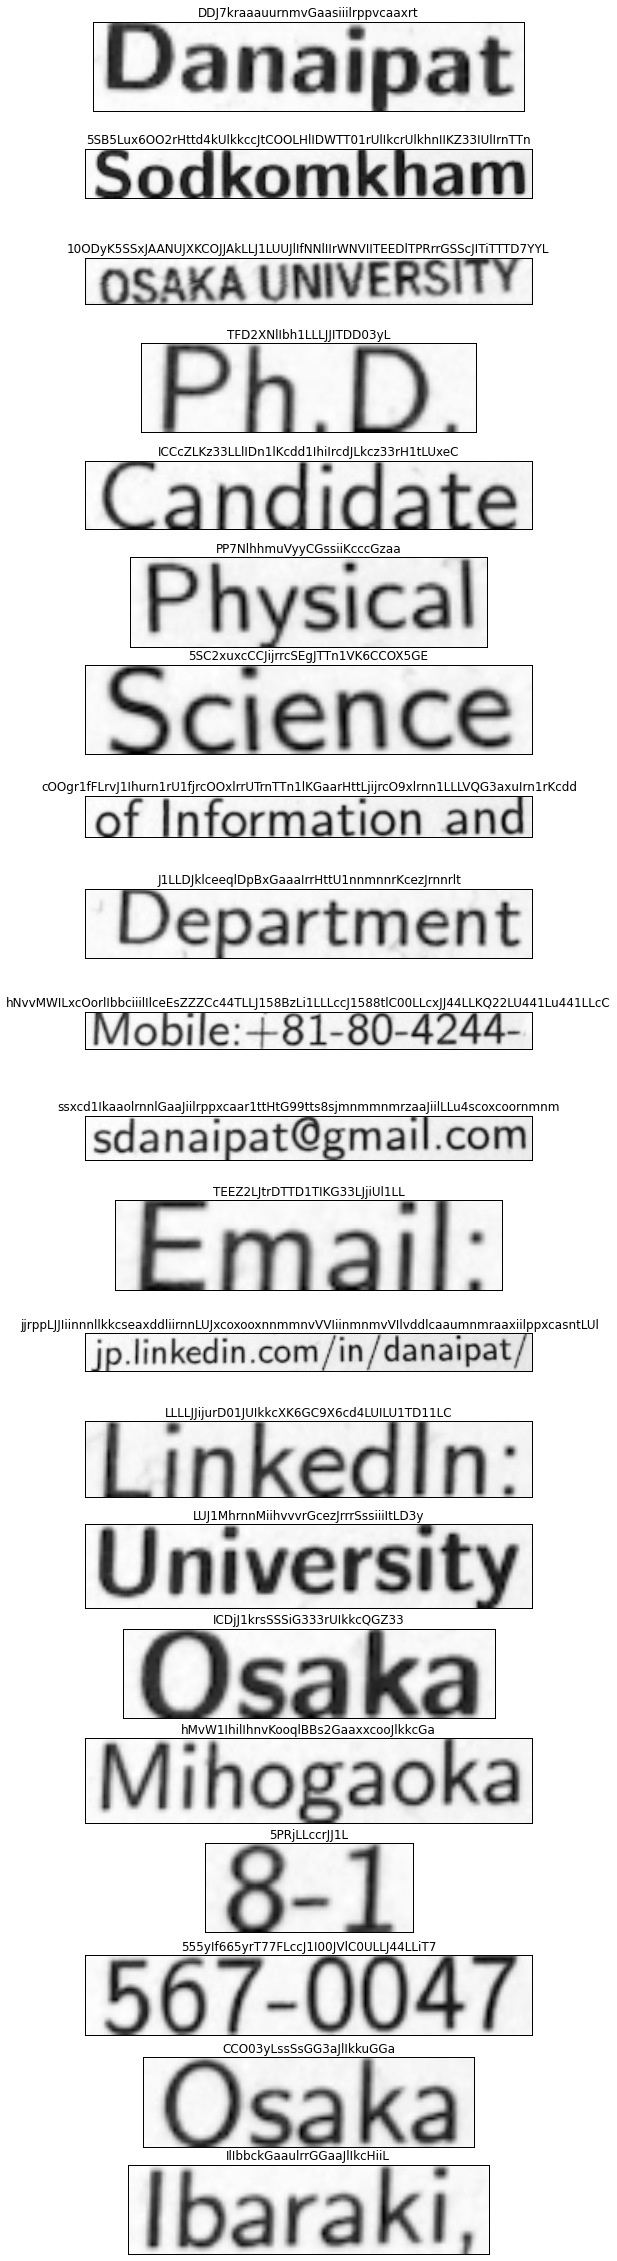

In [63]:
from skimage.transform import resize

plt.gcf().set_size_inches(8, 40)
for i, s in enumerate(segments):
    plt.subplot(len(segments), 1, i + 1)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    ratio = 1. * s.shape[0] / s.shape[1]
    im = resize(s.astype(np.float64), (H, int(H / ratio)))
    
    pred = []
    for i in range(0, im.shape[1] - W, 3):
        x = scaler.transform(im[:, i:i+W].reshape(1, -1))
        k = net2.predict(x.reshape(1, 1, H, W))
        pred.append(characters[k])
        
    plt.imshow(im, cmap=plt.cm.gray)
    plt.title("".join(pred))

In [110]:
plt.gcf().set_size_inches(15, 50)


s = segments[1]
ratio = 1. * s.shape[0] / s.shape[1]
im = resize(s.astype(np.float64), (H, int(H / ratio)))

for i in range(0, im.shape[1] - 28, 3):
    plt.subplot(im.shape[1] - W, 1, i + 1)
    plt.imshow(im[:, i: i + 28], cmap=plt.cm.gray)
    x = scaler.transform(im[:, i:i+W].reshape(1, -1))
    k = net2.predict(x.reshape(1, 1, H, W))
    plt.title(characters[k])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)